In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from tqdm import tqdm
from kerasbeats import prep_time_series, NBeatsModel
from keras import optimizers
import sys
import os
module_path = os.path.abspath(os.path.join(os.path.dirname(os.path.abspath('nbeats.ipynb')),'..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from data import preprocess, postprocess
from model import fft, lstm
from evaluate import evaluateModel, evaluateProfit

In [2]:
import yfinance as yf
import datetime
from dateutil.relativedelta import relativedelta
import numpy as np

class LoadData:
    def __init__(self, stock_name, window_length, slide_range, total_windows):
        """Initializes the LoadData class.

        Args:
            total_windows (int): The total number of windows.
            window_length (int): The length of each window.
        """
        self.stock_name = str(stock_name)
        self.window_length = int(window_length)
        self.slide_range = int(slide_range)
        self.total_windows = int(total_windows)
        
        self.train_data = np.ndarray(shape=(total_windows, window_length), dtype=float)
        self.train_data_index = np.ndarray(shape=(total_windows, window_length), dtype=object)
        self.test_data = np.ndarray(shape=(total_windows, window_length), dtype=float)
        self.test_data_index = np.ndarray(shape=(total_windows, window_length), dtype=object)

        self.date_data_start_list = []
        self.date_predict_start_list = []
        self.date_predict_end_list = []
        self.test_data_start_list = []

    def load_and_split_data(self, date_predict_start):
        """Loads and splits the data.

        Args:
            stock_name (str): The stock name.
            date_predict_start (str): The start date for prediction.
            window_length (int): The length of each window.
            slide_range (int): The slide range.
            total_windows (int): The total number of windows.

        Returns:
            train_data: numpy.ndarray
                The training data arrays.
                shape: (number of windows, window_length)
            test_data: numpy.ndarray
                The testing data arrays.
                shape: (number of windows, window_length)
        """

        all_data = yf.Ticker(self.stock_name).history(period='max')
        all_data.index = all_data.index.date
        date_predict_start = self._check_start(date_predict_start, all_data)
        predict_start = all_data.index.get_loc(date_predict_start)
        for i in range(self.total_windows):
            predict_end = predict_start + self.window_length
            data_start = predict_start - self.window_length
            self.train_data[i, :] = all_data['Close'].iloc[data_start:predict_start].values
            self.train_data_index[i, :] = all_data['Close'].iloc[data_start:predict_start].index
            self.test_data[i, :] = all_data['Close'].iloc[predict_start:predict_end].values
            self.test_data_index[i, :] = all_data['Close'].iloc[predict_start:predict_end].index
            predict_start = predict_start + self.slide_range
        return self.train_data, self.test_data, self.train_data_index, self.test_data_index, all_data

    def _check_start(self, date_predict_start, all_data):
        """Checks the start date for prediction.

        Args:
            date_predict_start (str): The start date for prediction.
            all_data (pandas.DataFrame): The complete data.

        Returns:
            datetime.date: The validated start date for prediction.
        """

        date_predict_start = datetime.datetime.strptime(
            date_predict_start, '%Y-%m-%d').date()
        check = date_predict_start in all_data.index
        while (check == False):
            date_predict_start = date_predict_start + \
                relativedelta(days=+1)
            check = date_predict_start in list(all_data.index)
        return date_predict_start
    
    def load_extra_train_data(self, date_predict_start, train_data_num, x_length):
        extra_train_data = np.ndarray(shape=(1, train_data_num*x_length), dtype=float)
        extra_train_data_index = np.ndarray(shape=(1, train_data_num*x_length), dtype=object)
        all_data = yf.Ticker(self.stock_name).history(period='max')
        all_data.index = all_data.index.date
        date_predict_start = self._check_start(date_predict_start, all_data)
        data_end = all_data.index.get_loc(date_predict_start)
        data_start = data_end - train_data_num*x_length
        extra_train_data[0, :] = all_data['Close'].iloc[data_start:data_end].values
        extra_train_data_index[0, :] = all_data['Close'].iloc[data_start:data_end].index
        return extra_train_data, extra_train_data_index

In [3]:
stock_name = "^GSPC"
date_predict_start = '2020-01-01'
window_length = 250
slide_range = 20
total_windows = 10

pv_range = 7
profit_percentage = 0.08
loss_percentage = 0.08

n_harm_lower_limit = 1
n_harm_upper_limit = 50
fit_method = 'rmse'

x_length = 10
y_length = 10
slide = 10

train_data_num = 1000
epochs = 100

In [4]:
# dataloader = loadData.LoadData(total_windows, window_length)
dataloader = LoadData(stock_name, window_length, slide_range, total_windows)
train_data, test_data, train_data_index, test_data_index, all_data =\
    dataloader.load_and_split_data(date_predict_start)


In [5]:
extra_train_data, extra_train_data_index = dataloader.load_extra_train_data(date_predict_start, train_data_num, x_length)
all_data_index = all_data.index
preprocesser = preprocess.Preprocess()
x_train, y_train, scaler =\
    preprocesser.preprocess_train_data(extra_train_data, x_length, y_length, slide=slide)
x_test, y_test, scaler =\
    preprocesser.preprocess_test_data(train_data, test_data, x_length, y_length, slide=slide)

In [6]:
class Nbeats:
    def __init__(self):
        pass
    
    def nbeats(self, x_train, y_train, x_test, y_test, train_data, test_data, y_length, epochs):
        """
        Trains and predicts using LSTM model.

        Args:
            x_train (array): Training input data.
            y_train (array): Training target data.
            x_test (array): Test input data.
            y_test (array): Test target data.
            test_data (array): Data for prediction.
            train_data (array): Training data.
            y_length (int): Length of the target data.

        Returns:
            array: Processed signal obtained from predictions.
        """
        model = self._build(x_train, y_length)
        history = self._train(train_data, model, x_train, y_train, epochs)
        predicted_y = self._predict(x_test, y_test, test_data, model)
        # processed_signal = self._flatten(predicted_y)
        return predicted_y, history

    def _construct(self, y_length):
        """
        Constructs an LSTM model.

        Args:
            y_length (int): Length of the target data.
            input_shape (tuple): Shape of the input data.

        Returns:
            Sequential: Constructed LSTM model.
        """
        model = NBeatsModel(model_type = 'generic', lookback = 1, horizon = y_length)
        return model
    
    def _build(self, x_train, y_length):
        """
        Builds a list of LSTM models.

        Args:
            x_train (array): Training input data.
            y_length (int): Length of the target data.

        Returns:
            list: List of built LSTM models.
        """
        model = self._construct(y_length)
        # model[i].compile(loss = 'mse',
        #          optimizer = optimizers.RMSprop(0.001))
        # model[i].summary()
        return model
    
    def _train(self, train_data, model, x_train, y_train, epochs):
        """
        Trains the LSTM models.

        Args:
            train_data (array): Training data.
            model (list): List of LSTM models.
            x_train (array): Training input data.
            y_train (array): Training target data.

        Returns:
            list: List of training histories.
        """
        earlystopper = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 2)
        history = model.fit(x_train, y_train, epochs=epochs)
        return history
    
    def _predict(self, x_test, y_test, test_data, model):
        """
        Generates predictions using the trained models.

        Args:
            x_test (array): Test input data.
            y_test (array): Test target data.
            test_data (array): Data for prediction.
            model (list): List of LSTM models.

        Returns:
            predicted_y: numpy.ndarray
                Processed signal obtained from predictions.
                shape = (number of windows, number of split y, length of y)
        """
        predicted_y = np.ndarray([y_test.shape[0], y_test.shape[1], y_test.shape[2]])
        for i in tqdm(range(0, test_data.shape[0])):
            predicted_prices = model.predict(x_test[i])
            predicted_y[i] = predicted_prices
        return predicted_y

In [7]:
# model = NBeatsModel(model_type = 'generic', lookback = y_length, horizon = y_length)

In [8]:
# x_train.shape

In [9]:
# x_train[0].flatten().shape

In [10]:
# for i in tqdm(range(0, train_data.shape[0])):
#     earlystopper = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 2)
#     history = model.fit(x_train[i].flatten(), y_train[i].flatten(), epochs=25)

In [11]:
model = Nbeats()
x_train = x_train.reshape((x_train.shape[1], x_train.shape[2]))
y_train = y_train.reshape((y_train.shape[1], y_train.shape[2]))
lstm_processed_signal, history = model.nbeats(x_train, y_train, x_test, y_test, train_data, test_data, y_length, epochs)

Epoch 1/100
10/10 [==============================] - 29s 2s/step - loss: 0.7836 - mae: 0.7836 - mape: 354.6982
Epoch 2/100
10/10 [==============================] - 25s 3s/step - loss: 0.2526 - mae: 0.2526 - mape: 103.8726
Epoch 3/100
10/10 [==============================] - 25s 2s/step - loss: 0.1430 - mae: 0.1430 - mape: 59.0646
Epoch 4/100
10/10 [==============================] - 23s 2s/step - loss: 0.0781 - mae: 0.0781 - mape: 31.7059
Epoch 5/100
10/10 [==============================] - 24s 2s/step - loss: 0.0676 - mae: 0.0676 - mape: 27.0498
Epoch 6/100
10/10 [==============================] - 23s 2s/step - loss: 0.0775 - mae: 0.0775 - mape: 31.4787
Epoch 7/100
10/10 [==============================] - 23s 2s/step - loss: 0.0657 - mae: 0.0657 - mape: 25.8718
Epoch 8/100
10/10 [==============================] - 25s 3s/step - loss: 0.0723 - mae: 0.0723 - mape: 29.9809
Epoch 9/100
10/10 [==============================] - 25s 2s/step - loss: 0.0412 - mae: 0.0412 - mape: 17.5863
Epoch 10

  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 4s 4s/step


 10%|█         | 1/10 [00:04<00:37,  4.21s/it]

1/1 [==============================] - 0s 136ms/step


 20%|██        | 2/10 [00:04<00:15,  1.89s/it]

1/1 [==============================] - 0s 128ms/step


 30%|███       | 3/10 [00:04<00:08,  1.15s/it]

1/1 [==============================] - 0s 126ms/step


 40%|████      | 4/10 [00:04<00:04,  1.26it/s]

1/1 [==============================] - 0s 96ms/step


 50%|█████     | 5/10 [00:05<00:02,  1.70it/s]

1/1 [==============================] - 0s 132ms/step


 60%|██████    | 6/10 [00:05<00:01,  2.12it/s]

1/1 [==============================] - 0s 113ms/step


 70%|███████   | 7/10 [00:05<00:01,  2.51it/s]

1/1 [==============================] - 0s 128ms/step


 80%|████████  | 8/10 [00:05<00:00,  2.87it/s]

1/1 [==============================] - 0s 138ms/step


 90%|█████████ | 9/10 [00:06<00:00,  2.93it/s]

1/1 [==============================] - 0s 166ms/step


100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


In [12]:
import matplotlib.pyplot as plt

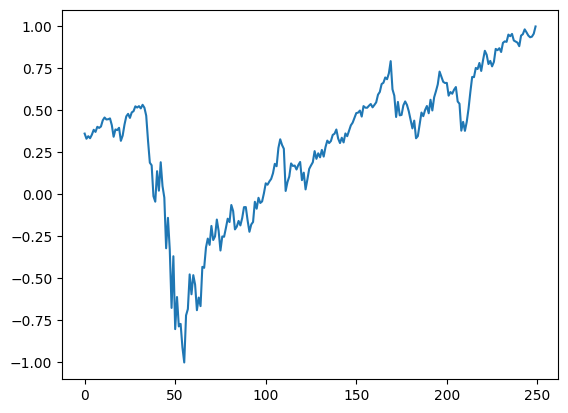

In [13]:
plt.plot(y_test[0].flatten())

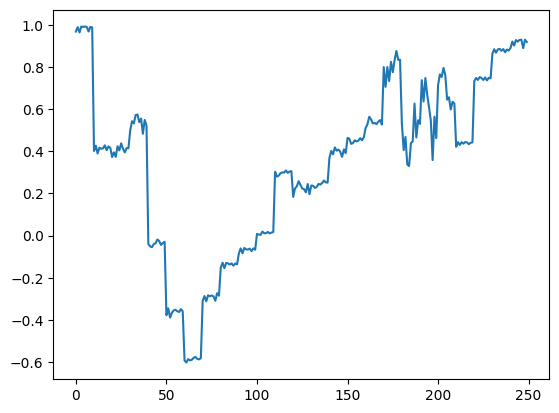

In [14]:
plt.plot(lstm_processed_signal[0].flatten())

In [15]:
# # initialize N-Beats and fit
# nbeats = NBeatsModel(model_type = 'generic', lookback = x_length, horizon = 1)
# nbeats.fit(x_train[0], y_train[0], epochs = 30)

In [16]:
post = postprocess.Postprocess()
processed_signal = post.postprocess_lstm(lstm_processed_signal, scaler)
pv_train_data = post.find_data_pv(train_data, pv_range)
pv_test_data = post.find_data_pv(test_data, pv_range)
pv_signal = post.find_data_pv(processed_signal, pv_range)
lead_train = post.find_lead(pv_train_data, pv_signal)
lead_test = post.find_lead(pv_test_data, pv_signal)
first_date, lead, pv = post.get_first_lead(pv_signal, lead_test)

In [17]:
# processed_signal, best_fit_harm, best_fit_error = post.postprocess_fft(
#     mixed_train_harm, mixed_test_harm, pv_range, pv_train_data, fit_method)
# pv_signal = post.find_data_pv(processed_signal, pv_range)

In [18]:
lead_train = post.find_lead(pv_train_data, pv_signal)
lead_test = post.find_lead(pv_test_data, pv_signal)
first_date, lead, pv = post.get_first_lead(pv_signal, lead_test)

In [19]:
best_fit_harm = None
best_fit_error = None

In [20]:
evaluater = evaluateModel.Evaluate()
result_table, average_lead = evaluater.evaluate_model(processed_signal, all_data_index, test_data_index, best_fit_harm, best_fit_error, first_date, lead, pv)
print('average_lead = ', average_lead)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    display(result_table)

average_lead =  6.7


,s_date,t_date,lead,ans_date,pv,best_fit,error
0,2020-01-02,2020-01-06,-1,2020-01-03,valley,NaN,NaN
1,2020-01-31,2020-02-03,11,2020-02-19,peak,NaN,NaN
2,2020-03-02,2020-03-12,-6,2020-03-04,peak,NaN,NaN
3,2020-03-30,2020-04-01,0,2020-04-01,valley,NaN,NaN
4,2020-04-28,2020-04-30,1,2020-05-01,valley,NaN,NaN
5,2020-05-27,2020-06-08,0,2020-06-08,peak,NaN,NaN
6,2020-06-24,2020-07-07,11,2020-07-22,peak,NaN,NaN
7,2020-07-23,2020-08-04,21,2020-09-02,peak,NaN,NaN
8,2020-08-20,2020-08-21,8,2020-09-02,peak,NaN,NaN
9,2020-09-18,2020-09-30,8,2020-10-12,peak,NaN,NaN


evaluater = evaluateProfit.EvaluateProfit()

In [21]:
evaluater = evaluateProfit.EvaluateProfit()

total_profit = 261.4599609375


,in_date,in_price,out_date,out_price,pv,profit,profitability
0,2020-01-06,3217.55,2020-01-15,3289.29,valley,71.74,0.0223 %
1,2020-02-03,3235.66,2020-02-12,3379.45,peak,-143.79,-0.0444 %
2,2020-03-12,2630.86,2020-03-23,2237.4,peak,393.46,0.1496 %
3,2020-04-01,2498.08,2020-04-13,2761.63,valley,263.55,0.1055 %
4,2020-04-30,2930.91,2020-05-11,2930.19,valley,-0.72,-0.0002 %
5,2020-06-08,3199.92,2020-06-17,3113.49,peak,86.43,0.027 %
6,2020-07-07,3166.44,2020-07-16,3215.57,peak,-49.13,-0.0155 %
7,2020-08-04,3289.92,2020-08-13,3373.43,peak,-83.51,-0.0254 %
8,2020-08-21,3386.01,2020-09-01,3526.65,peak,-140.64,-0.0415 %
9,2020-09-30,3341.21,2020-10-09,3477.14,peak,-135.93,-0.0407 %


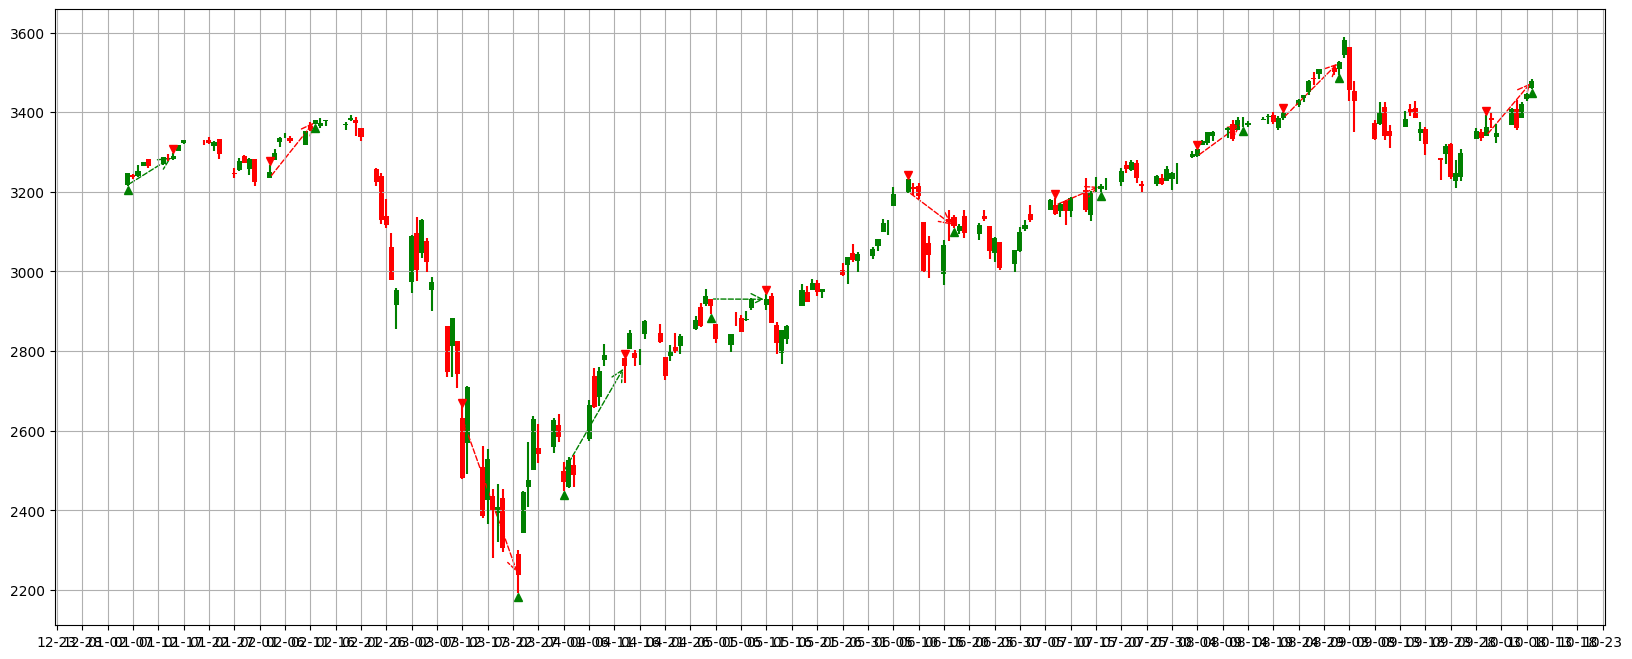

In [22]:
total_profit, profit_table = evaluater.build_profit_table_strategy_1(result_table, all_data, pv_range)
print('total_profit =', total_profit)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    display(profit_table)
evaluater.draw_profit_plot(profit_table, all_data)

total_profit = 14.765166015625255


,in_date,in_price,out_date,out_price,pv,profit,strategy,strategy_price,profitability
0,2020-01-06,3217.55,2020-01-15,3289.29,valley,71.74,NaN,NaN,0.0223 %
1,2020-02-03,3235.66,2020-02-12,3379.45,peak,-143.79,NaN,NaN,-0.0444 %
2,2020-03-12,2630.86,2020-03-16,2420.391,peak,210.469,stop_profit,2420.391,0.08 %
3,2020-04-01,2498.08,2020-04-07,2697.926,valley,199.846,stop_profit,2697.926,0.08 %
4,2020-04-30,2930.91,2020-05-11,2930.19,valley,-0.72,NaN,NaN,-0.0002 %
5,2020-06-08,3199.92,2020-06-17,3113.49,peak,86.43,NaN,NaN,0.027 %
6,2020-07-07,3166.44,2020-07-16,3215.57,peak,-49.13,NaN,NaN,-0.0155 %
7,2020-08-04,3289.92,2020-08-13,3373.43,peak,-83.51,NaN,NaN,-0.0254 %
8,2020-08-21,3386.01,2020-09-01,3526.65,peak,-140.64,NaN,NaN,-0.0415 %
9,2020-09-30,3341.21,2020-10-09,3477.14,peak,-135.93,NaN,NaN,-0.0407 %


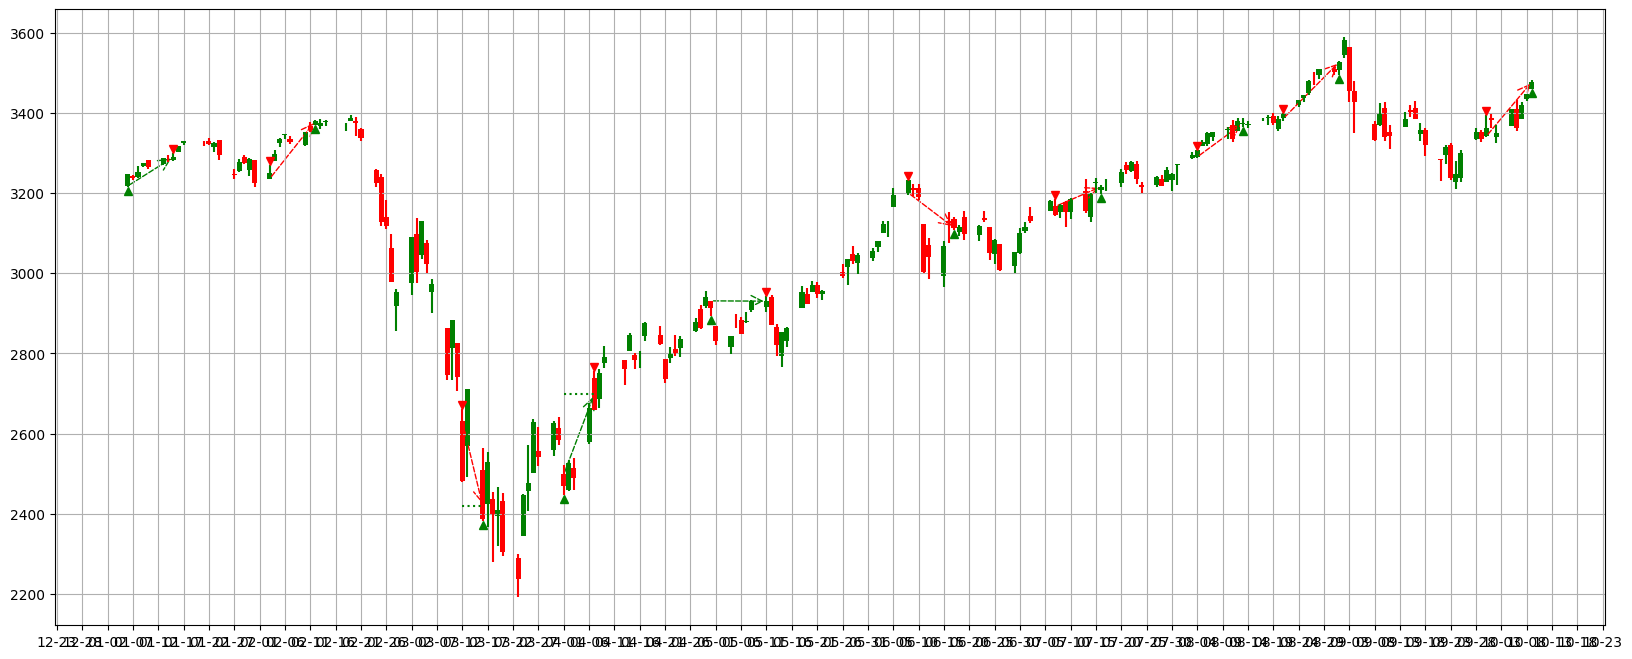

In [23]:
total_profit, profit_table = evaluater.build_profit_table_strategy_2(result_table, all_data, profit_percentage, loss_percentage, pv_range)
print('total_profit =', total_profit)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    display(profit_table)
evaluater.draw_profit_plot(profit_table, all_data)

total_profit = -23.209628906250146


,in_date,in_price,out_date,out_price,pv,profit,strategy,strategy_price,profitability
0,2020-01-06,3217.55,2020-01-15,3289.29,valley,71.74,NaN,NaN,0.0223 %
1,2020-02-03,3235.66,2020-02-12,3379.45,peak,-143.79,NaN,NaN,-0.0444 %
2,2020-03-12,2630.86,2020-03-12,2522.069,peak,108.791,stop_profit,2522.069,0.0414 %
3,2020-04-01,2498.08,2020-04-13,2761.63,valley,263.55,NaN,NaN,0.1055 %
4,2020-04-30,2930.91,2020-05-11,2930.19,valley,-0.72,NaN,NaN,-0.0002 %
5,2020-06-08,3199.92,2020-06-17,3113.49,peak,86.43,NaN,NaN,0.027 %
6,2020-07-07,3166.44,2020-07-16,3215.57,peak,-49.13,NaN,NaN,-0.0155 %
7,2020-08-04,3289.92,2020-08-13,3373.43,peak,-83.51,NaN,NaN,-0.0254 %
8,2020-08-21,3386.01,2020-09-01,3526.65,peak,-140.64,NaN,NaN,-0.0415 %
9,2020-09-30,3341.21,2020-10-09,3477.14,peak,-135.93,NaN,NaN,-0.0407 %


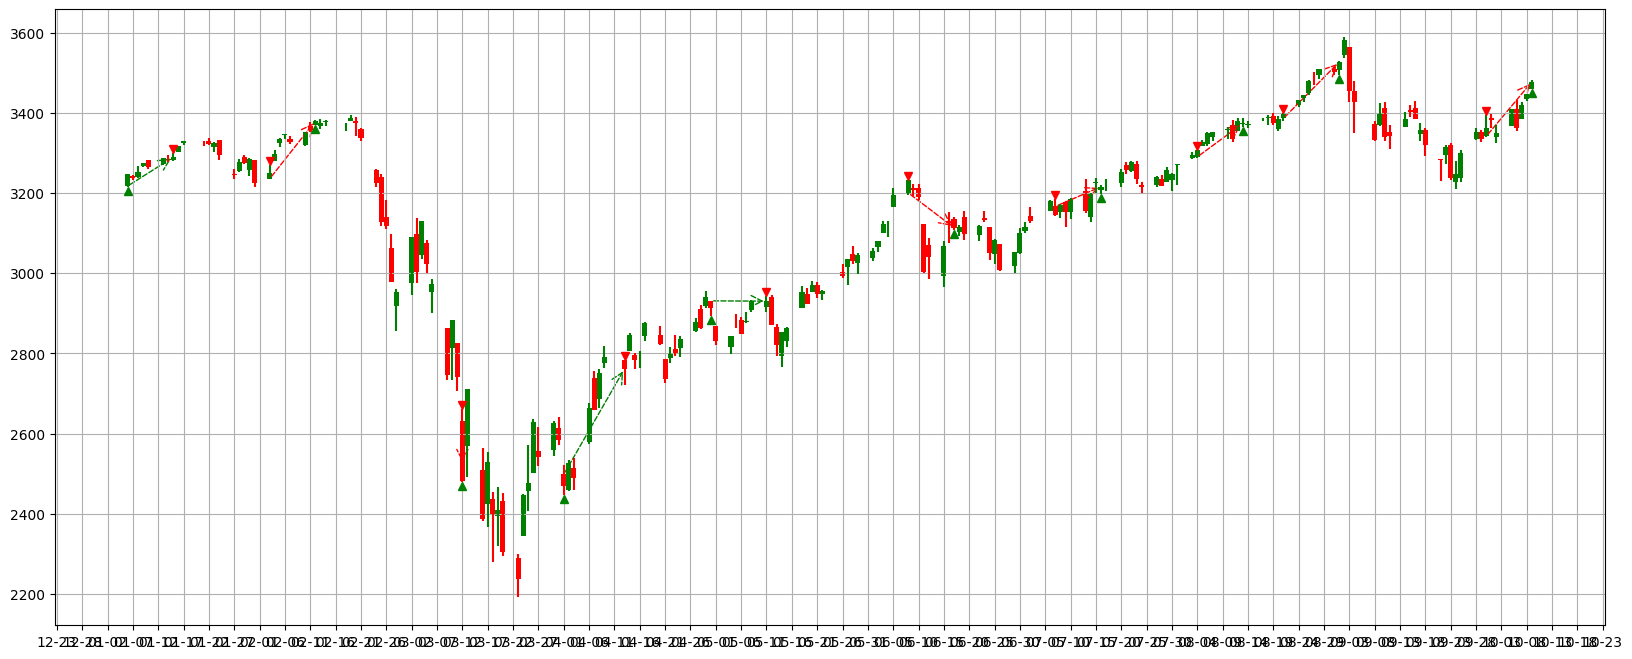

In [24]:
total_profit, profit_table = evaluater.build_profit_table_strategy_3(result_table, all_data, profit_percentage, loss_percentage, pv_range)
print('total_profit =', total_profit)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    display(profit_table)
evaluater.draw_profit_plot(profit_table, all_data)

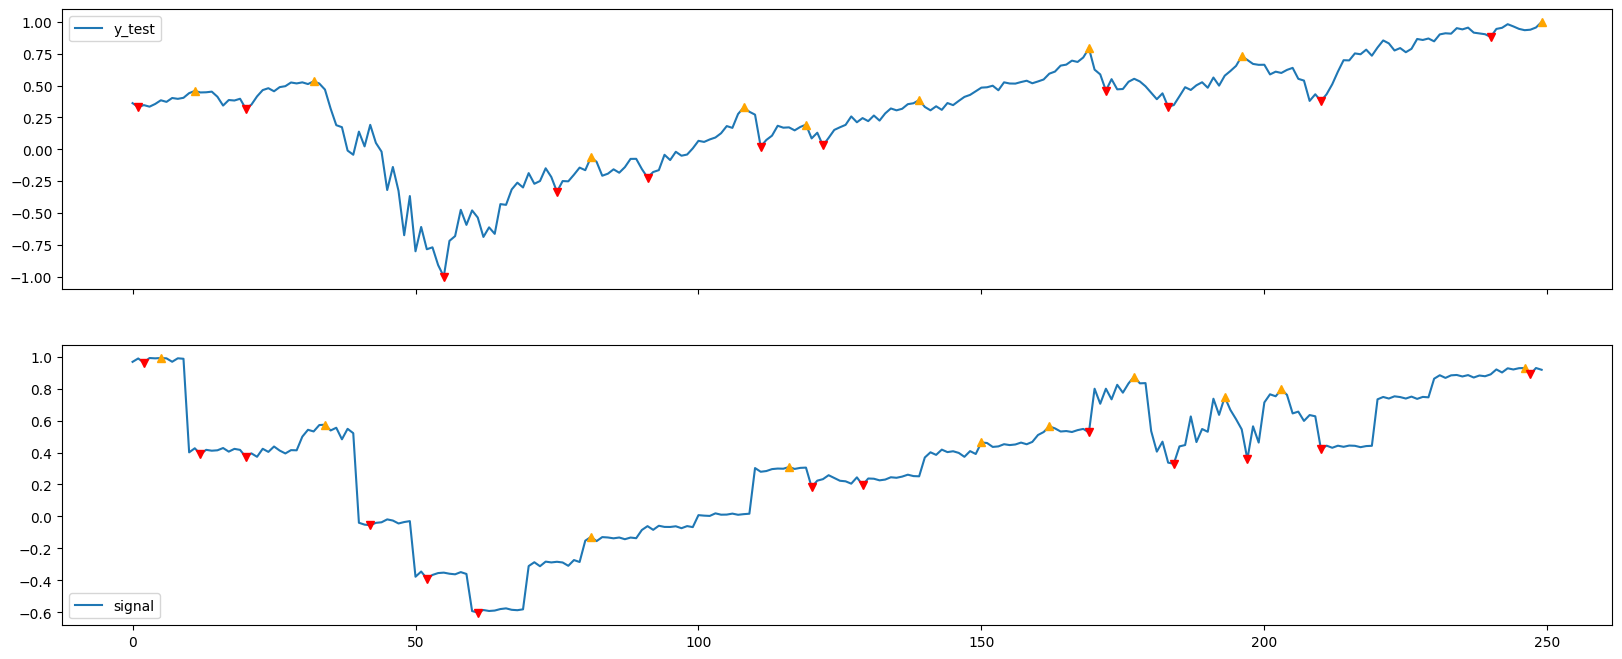

In [25]:
fig, ax = plt.subplots(2, 1, figsize=(20, 8), sharex=True)
ax[0].plot(y_test[0].flatten(), label='y_test')
ax[1].plot(lstm_processed_signal[0].flatten(), label='signal')
for x , pv in enumerate(pv_test_data[0]):
    if pv == 1:
        ax[0].plot(x, y_test[0].flatten()[x], '^', color='orange')
    elif pv == -1:
        ax[0].plot(x, y_test[0].flatten()[x], 'v', color='red')
for x , pv in enumerate(pv_signal[0]):
    if pv == 1:
        ax[1].plot(x, lstm_processed_signal[0].flatten()[x], '^', color='orange')
    elif pv == -1:
        ax[1].plot(x, lstm_processed_signal[0].flatten()[x], 'v', color='red')
ax[0].legend()
ax[1].legend()
plt.show()

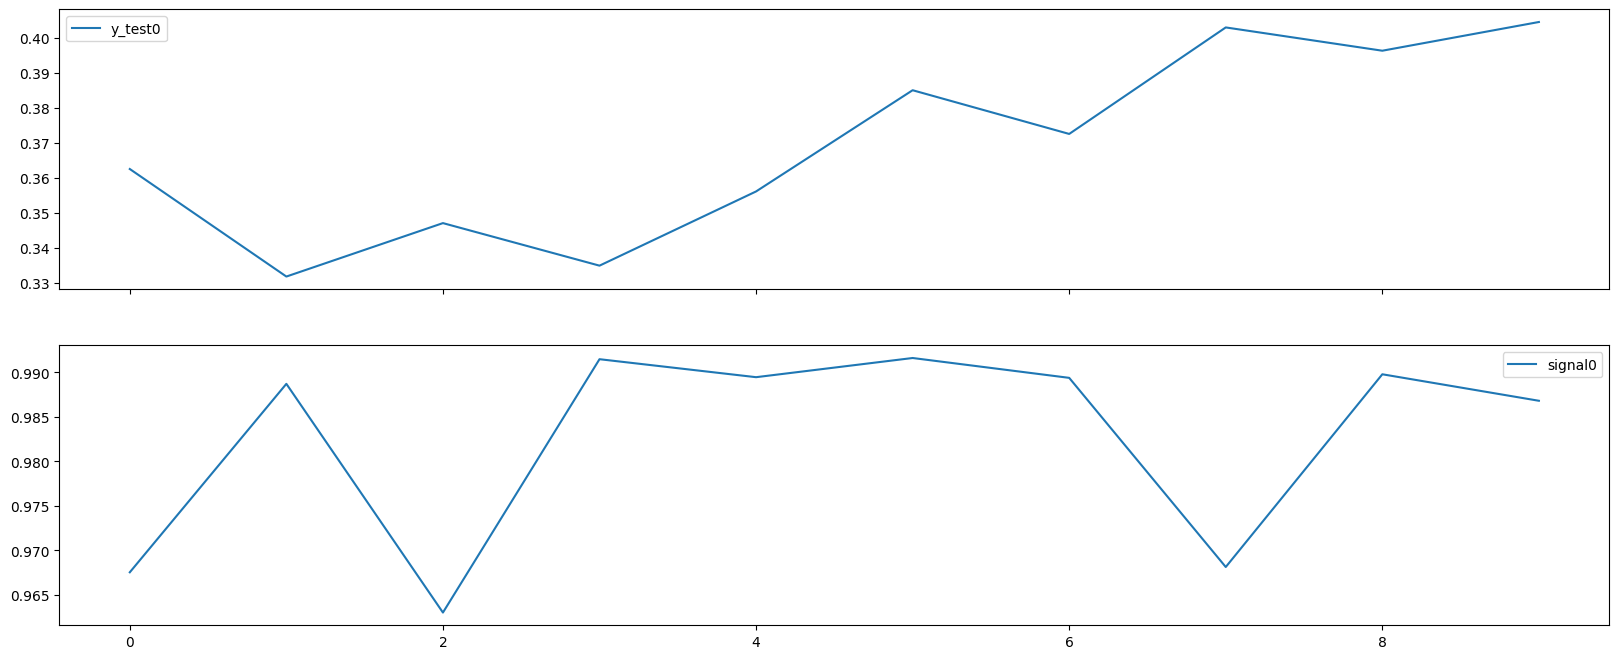

In [31]:
fig, ax = plt.subplots(2, 1, figsize=(20, 8), sharex=True)
count=0
for i in range(0, 1): 
    countx=range(count, count+10)
    ax[0].plot(countx, y_test[0][i], label=f'y_test{i}')
    ax[1].plot(countx, lstm_processed_signal[0][i], label=f'signal{i}')
    count+=10
ax[0].legend()
ax[1].legend()
plt.show()